GPU

In [1]:
!nvidia-smi

Fri Sep 22 06:17:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import os
import numpy as np
import random
from tqdm.auto import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import cv2
from skimage.io import imread, imshow, show

from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

seed = 42
np.random.seed = seed  # To get same random seed everytime we run the whole thing.
tf.random.set_seed(42)
random.seed(seed)

In [3]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.4 MB/s eta 0:00:00


In [4]:
import tensorflow_addons as tfa

## Drive Mount

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [9]:
H1_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H1/*"
H2_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H2/*"
H3_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H3/*"
H5_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H5/*"
H6_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H6/*"

In [ ]:
def sorted_file_paths(path):
    file_paths = sorted(glob(path))
    print("Total image files:")
    print(f"{len(file_paths)} \n")
    return file_paths

H1_file_paths = sorted_file_paths(H1_path)
H2_file_paths = sorted_file_paths(H2_path)
H3_file_paths = sorted_file_paths(H3_path)
H5_file_paths = sorted_file_paths(H5_path)
H6_file_paths = sorted_file_paths(H6_path)

Total image files:
4357 

Total image files:
2314 

Total image files:
816 

Total image files:
814 

Total image files:
739 



In [ ]:
all_file_paths = H1_file_paths + H2_file_paths + H3_file_paths + H5_file_paths + H6_file_paths
print(len(all_file_paths))
print(4357+2314+816+814+739)

9040
9040


In [6]:
def image_preprocess(paths):
    total = len(paths)
    im_array = np.zeros((total, 224, 224, 3), dtype = np.float32)
    for i in tqdm(range(total)):
        img = imread(paths[i])  # Numpy Array = (500,500,3)
        # print(image.shape)
        img = cv2.resize(img, (224, 224))
        # img = img / 255.0
        im_array[i, :,:,:] = img
    return im_array

# X = image_preprocess(all_file_paths)
X = np.load("/content/drive/MyDrive/ICCIT 2023/npy_files/array_9040_224.npy")
print(X.shape)
print(X.dtype)

(9040, 224, 224, 3)
float32


In [ ]:
# np.save("/content/drive/MyDrive/ICCIT 2023/npy_files/array_9040_224.npy", X)

In [10]:
labels = ['H1']*4357 + ['H2']*2314 + ['H3']*816 + ['H5']*814 + ['H6']*739
print(type(labels))
print(len(labels))
# print(labels[3300])
# print(labels)

<class 'list'>
9040


In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(labels)
print(y.shape)
print(y)
print('\n')


classes = list(label_enconder.classes_)
print(classes)
print('\n')

(9040,)
[0 0 0 ... 4 4 4]


['H1', 'H2', 'H3', 'H5', 'H6']




In [12]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(X.dtype, y.dtype)
# All are 4D and 1D array.

(9040, 224, 224, 3) (9040,)
float32 float32


## Vit Model creation

In [20]:
input_size = 224
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 30
num_epochs = 200
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024]

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [21]:
def create_vit_part(input, aug_layer):

    # input_shape = (input_size, input_size, 3)
    # num_classes = 5
    # inputs = layers.Input(shape=input_shape)
    # Augment data.

    augmented = aug_layer(input)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)  #9216
    # Add MLP.
    # features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    # model = keras.Model(inputs=inputs, outputs=logits)

    x = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation=tf.nn.relu)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation=tf.nn.relu)(x)

    return x  #512

# vit_model = create_vit_classifier(data_augmentation)
# vit_model.summary()


## Transfer Learning Model

In [22]:


def transfer_model(input):

    base_model = tf.keras.applications.vgg16.VGG16(
                                                include_top=False,
                                                weights='imagenet',
                                                input_shape=(input_size, input_size, 3),
                                                pooling=None)

    base_model.trainable = False

    data_augmentation_vgg16 = keras.Sequential([layers.RandomFlip("horizontal"),
                                          layers.RandomRotation(factor=0.02),
                                          layers.RandomZoom(height_factor=0.1, width_factor=0.1)],
                                          name="vgg16_augmentation")

    vgg_preprocess = preprocess_input(input)
    x = data_augmentation_vgg16(vgg_preprocess)
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.6)(x)
    # x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # output = tf.keras.layers.Dense(no_class, activation="softmax")(x)

    # model = keras.Model(inputs = input, outputs = output)

    return x #(512,)

# model = creat_model()
# print(model.summary())

## Casceding Model Creation

In [23]:
def Cascade_model(Vit_aug_layer):

    input = keras.Input(shape=(input_size, input_size, 3))  # (None, 224, 224, 3)
    num_classes = 5

    vit_output = create_vit_part(input, Vit_aug_layer)       #(None, 512)
    tranfer_output = transfer_model(input)    #(None, 512)

    multiplied = layers.Multiply()([vit_output, tranfer_output])
    x = layers.Dropout(0.5)(multiplied)

    x = tf.keras.layers.Dense(256,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs = input, outputs = output)

    return model

In [ ]:
model = Cascade_model(data_augmentation)
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [25]:
def metric_calculation(true, out):

    f1_metric = tf.keras.metrics.F1Score()
    f1_metric.update_state(true, out)
    f1_scores = f1_metric.result().numpy()
    f1 = np.mean(f1_scores)

    pred = np.zeros((true.shape[0],5))
    for i in range(true.shape[0]):
        indx = np.argmax(out[i,:])
        pred[i,indx] = 1

    recall_scores = []
    pre_scores =[]
    for i in range(5):
        re_metric = tf.keras.metrics.Recall()
        pre_metric = tf.keras.metrics.Precision()
        re_metric.update_state(true[:,i],pred[:,i])
        pre_metric.update_state(true[:,i],pred[:,i])

        recall_scores.append(re_metric.result().numpy())
        pre_scores.append(pre_metric.result().numpy())

    recall = np.mean(np.array(recall_scores))
    precision = np.mean(np.array(pre_scores))

    return precision, recall, f1

In [26]:
acc_per_fold = []
history_all = []
f1_all = []
pre_all = []
rec_all = []

In [27]:
x_train = 0
x_test =0
y_train = 0
y_test = 0

In [28]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

fold_no = 1


for train, test in cv.split(X, y):

    print('   ')
    print(f'Training for fold {fold_no} ...', '\n')

    x_train = X[train]
    x_test = X[test]
    y_train = y[train]
    y_test = y[test]

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

    data_augmentation_Vit = keras.Sequential([layers.Normalization(),
                                          layers.Resizing(image_size, image_size),
                                          layers.RandomFlip("horizontal"),
                                          layers.RandomRotation(factor=0.02),
                                          layers.RandomZoom(height_factor=0.2, width_factor=0.2)],
                                          name="vit_augmentation")


    data_augmentation_Vit.layers[0].adapt(x_train)

    model = Cascade_model(data_augmentation_Vit)

    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                     weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])


    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_test, y_test))

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%", '\n')

    prediction = model.predict(x_test)
    pre, rec, f1 = metric_calculation(y_test, prediction)

    print(f"F1 Score: {round(f1 * 100, 2)}%", '\n')
    print(f"Precision: {round(pre * 100, 2)}%", '\n')
    print(f"Recall: {round(rec * 100, 2)}%", '\n')

    acc_per_fold.append(accuracy*100)
    f1_all.append(f1)
    pre_all.append(pre)
    rec_all.append(rec)
    history_all.append(history)

    fold_no = fold_no + 1
    if fold_no == 2: break

   
Training for fold 1 ... 

Epoch 1/200
242/242 [==============================] - 68s 206ms/step - loss: 1.8825 - accuracy: 0.4703 - val_loss: 1.0338 - val_accuracy: 0.5896
Epoch 2/200
242/242 [==============================] - 45s 185ms/step - loss: 1.2213 - accuracy: 0.5557 - val_loss: 1.0059 - val_accuracy: 0.5769
Epoch 3/200
242/242 [==============================] - 46s 188ms/step - loss: 1.1310 - accuracy: 0.5712 - val_loss: 0.9590 - val_accuracy: 0.6045
Epoch 4/200
242/242 [==============================] - 46s 190ms/step - loss: 1.0724 - accuracy: 0.5915 - val_loss: 0.9070 - val_accuracy: 0.6173
Epoch 5/200
242/242 [==============================] - 46s 191ms/step - loss: 1.0102 - accuracy: 0.5986 - val_loss: 0.8650 - val_accuracy: 0.6355
Epoch 6/200
242/242 [==============================] - 46s 192ms/step - loss: 0.9840 - accuracy: 0.6088 - val_loss: 0.9088 - val_accuracy: 0.6184
Epoch 7/200
242/242 [==============================] - 46s 192ms/step - loss: 0.9191 - accurac

## Analysis

In [29]:
print(acc_per_fold, '\n')

mean = np.mean(np.array(acc_per_fold))
std = np.std(np.array(acc_per_fold))

print(f"Overall Accuracy is : {mean}+-{std}")

[82.356196641922] 

Overall Accuracy is : 82.356196641922+-0.0


In [30]:
print(f1_all, '\n')

mean = np.mean(np.array(f1_all))
std = np.std(np.array(f1_all))

print(f"F1 Score is : {mean}+-{std}")

[0.8279387] 

F1 Score is : 0.8279386758804321+-0.0


In [32]:
print(pre_all, '\n')

mean = np.mean(np.array(pre_all))
std = np.std(np.array(pre_all))

print(f"Precision is : {mean}+-{std}")

[0.873541] 

Precision is : 0.873540997505188+-0.0


In [33]:
print(rec_all, '\n')

mean = np.mean(np.array(rec_all))
std = np.std(np.array(rec_all))

print(f"Recall is : {mean}+-{std}")

[0.8018053] 

Recall is : 0.801805317401886+-0.0


In [34]:
print(len(history_all))

1


## History an File Saving to Numpy Array

In [36]:
history_nparray = np.zeros((4, 200))
print(len(history_all[0].history))

count = 0

for k in tqdm(range(1)):

    aa = history_all[k].history      # Dictionary

    history_nparray[count, :] = np.array(aa['loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['accuracy'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_accuracy'])
    count = count+1

print(count)
print(history_nparray[-1,:])

4


  0%|          | 0/1 [00:00<?, ?it/s]

4
[0.58960176 0.57688051 0.6045354  0.61725664 0.63550884 0.61836284
 0.6454646  0.67477876 0.66648233 0.67809737 0.70464599 0.70077431
 0.69524336 0.71349555 0.71460176 0.72566372 0.70353985 0.72068584
 0.71792036 0.71294248 0.71073008 0.72455752 0.69524336 0.73672569
 0.73119467 0.73727876 0.74004424 0.71792036 0.74059737 0.70851767
 0.73340708 0.76714599 0.76327431 0.76438051 0.76880533 0.76050884
 0.74557525 0.76382744 0.7693584  0.77876109 0.76493365 0.77488941
 0.76050884 0.77820796 0.7715708  0.78207964 0.78871679 0.78650445
 0.77931416 0.78484511 0.78207964 0.7909292  0.78429204 0.79701328
 0.79646015 0.7931416  0.77876109 0.77212387 0.78539824 0.80309737
 0.79977876 0.80696905 0.79535401 0.77323008 0.79424781 0.80088496
 0.80420351 0.78871679 0.79701328 0.81084073 0.8136062  0.80862832
 0.80254424 0.80088496 0.8136062  0.81305307 0.79756635 0.79535401
 0.80199116 0.79701328 0.79922569 0.79535401 0.7931416  0.8113938
 0.81194693 0.81581861 0.80752212 0.80475664 0.80862832 0.805

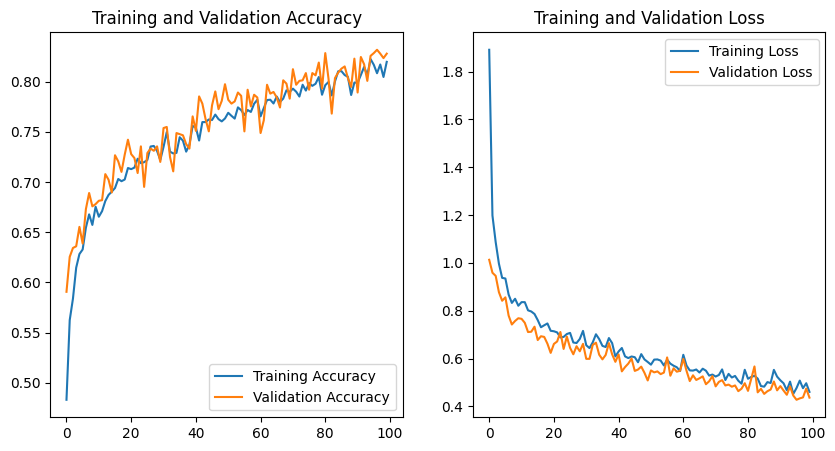

In [83]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(100), history_nparray[5,:], label='Training Accuracy')
plt.plot(range(100), history_nparray[7,:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), history_nparray[4,:], label='Training Loss')
plt.plot(range(100), history_nparray[6,:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
np.save('/content/VGG16_ViT_9040_History_3.npy', history_nparray)

# acc_f1_pre_rec = np.zeros((4,3))
# acc_f1_pre_rec[0,:] = np.array(acc_per_fold)
# acc_f1_pre_rec[1,:] = np.array(f1_all)
# acc_f1_pre_rec[2,:] = np.array(pre_all)
# acc_f1_pre_rec[3,:] = np.array(rec_all)

# np.save('/content/VGG16_ViT_9040_Metric_2.npy', acc_f1_pre_rec)

In [88]:
print(y_test.shape, prediction.shape)

(1808, 5) (1808, 5)


In [ ]:
print(y_test.shape)
print(prediction.shape)

y_pred = np.zeros((y_test.shape[0],5))
for i in range(y_test.shape[0]):
      indx = np.argmax(prediction[i,:])
      y_pred[i,indx] = 1

correct = 0
for i in range(y_pred.shape[0]):
    if np.sum(y_test[i,:]==y_pred[i,:]) == 5:
        correct = correct + 1
accuracy = correct / y_test.shape[0]
print(accuracy*100)

truelabel = []
predlabel = []

for i in range(y_test.shape[0]):
    if y_test[i, 0] == 1:
        truelabel.append("H1")
    if y_test[i, 1] == 1:
        truelabel.append("H2")
    if y_test[i, 2] == 1:
        truelabel.append("H3")
    if y_test[i, 3] == 1:
        truelabel.append("H5")
    if y_test[i, 4] == 1:
        truelabel.append("H6")
truelabel = np.array(truelabel)

for i in range(y_pred.shape[0]):
    if y_pred[i, 0] == 1:
        predlabel.append("H1")
    if y_pred[i, 1] == 1:
        predlabel.append("H2")
    if y_pred[i, 2] == 1:
        predlabel.append("H3")
    if y_pred[i, 3] == 1:
        predlabel.append("H5")
    if y_pred[i, 4] == 1:
        predlabel.append("H6")

truelabel = np.array(truelabel)
predlabel = np.array(predlabel)

temp = 0
for i in range(truelabel.shape[0]):
    if truelabel[i] == predlabel[i]: temp = temp + 1
print(temp*100/truelabel.shape[0])

(1808, 5)
(1808, 5)
86.67035398230088
86.67035398230088


In [ ]:
np.save('/content/ResNet_ViT_full_truelabel.npy', truelabel)
np.save('/content/ResNet_ViT_full_predlabel.npy', predlabel)